In [2]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import seaborn as sns


%matplotlib inline

## Cairo stuff - offload to somewhere else

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (y*(h/2) + h/2)))
    return xp, yp

# Make a point on a unit cirle given an angle
def point_on_circle(angle):
    x, y = math.cos(angle), math.sin(angle)
    return x, y

# Drae a set of emitters and detectors
def draw_des(ds, es, width, height):

    ## Cairo STUFF

    width, height = 600, 600

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e[0], e[1], width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d[0], d[1], width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d[0], d[1], width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e[0], e[1], width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def random_test_image(w, h, r, max_displacement):
    # A random circle within the unit circle
    x, y = 1, 1
    while (x**2 + y**2 > max_displacement**2): # Some margin to avoid overlapping the circles circumference
        x, y = random.random(), random.random() # Shouldn't take too long
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
    xp -= r
    yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
    xp -= r
    yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            x0, y0 = point_to_pixelf(*e, width, height)
            x1, y1 = point_to_pixelf(*d, width, height)

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def get_random_des(nd, ne):
    ds, es = [], []
    for i in range(nd):
        ds.append(point_on_circle((2*i/nd+(random.random()-0.5)*0.3)*3.14159265))
    for i in range(ne):
        es.append(point_on_circle((2*i/ne+(random.random()-0.5)*0.3)*3.14159265))
    return ds, es

def interp(start, end, width, height, img):
    x0, y0 = point_to_pixelf(*start, width, height)
    x1, y1 = point_to_pixelf(*end, width, height)

    # Make samplng points
    length = int(np.hypot(x1-x0, y1-y0))
    x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

    # Extract the values along the line
    zi = img[x.astype(np.int), y.astype(np.int)]
    return sum(zi), zi

def e_vs_t_pos():
    X, y, Xt, yt = [], [], [], []

    # 100 tests
    for i in range(100):
        s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
        paths = get_paths(img, ds, es, 256, 256)
        Xt.append(paths)
        yt.append([xi,yi])

    # 1000 training samples
    for i in range(1024):
        s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
        paths = get_paths(img, ds, es, 256, 256)
        X.append(paths)
        y.append([xi,yi])

    # Instantiate the model
    from sklearn.preprocessing import StandardScaler
    from sklearn.neural_network import MLPRegressor

    # Scale the inputs (important)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    Xt = scaler.transform(Xt)

    # for i in range(11): # 2^10 = 1024
    #     n = 2**i
    #     print(n)
    #     mlp = MLPRegressor(hidden_layer_sizes=(20,20,20))


    #     # Train the neural network
    #     mlp.fit(X[:n], y[:n])

    #     # Predict the positions of the test images from the test inputs
    #     predictions = mlp.predict(Xt)
    #     e = predictions.clip(0, 1)-yt
    #     errors = [(d[0]**2 + d[1]**2)**0.5 for d in e ]
    #     print(sum(errors))

    ses = []
    ns = range(10, 1000, 20)
    for n in ns: # 2^10 = 1024
        mlp = MLPRegressor(hidden_layer_sizes=(20,20,20))
        # Train the neural network
        mlp.fit(X[:n], y[:n])
        # Predict the positions of the test images from the test inputs
        predictions = mlp.predict(Xt)
        e = predictions.clip(0, 1)-yt
        errors = [(d[0]**2 + d[1]**2)**0.5 for d in e ]
        ses.append(sum(errors))
    plt.plot(ns, ses, label='Error vs N training samples')


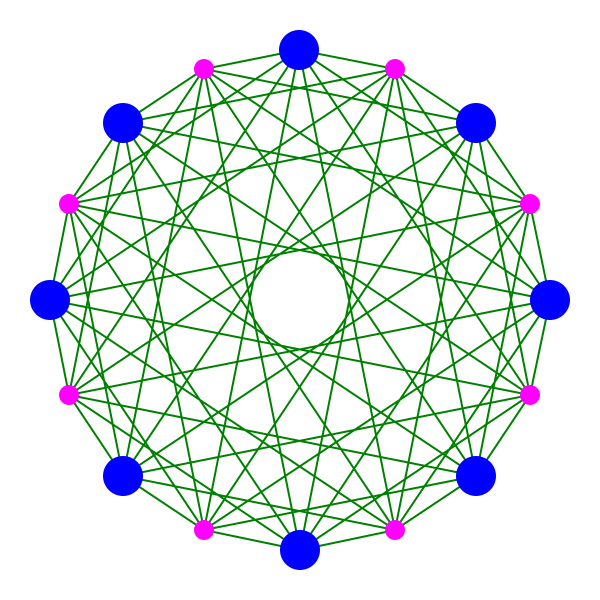

In [3]:
# GENERATE EMITTERS AND DETECTORS in ds and es (coordinate space from -1 to 1 x and y)
ds, es = [], []

for i in range(8):
    angle = (2*i/8)*math.pi
    xd, yd = 5*math.cos(angle)/6, 5*math.sin(angle)/6
    ds.append([xd, yd])
    angle += math.pi/8
    xe, ye = 5*math.cos(angle)/6, 5*math.sin(angle)/6
    es.append([xe, ye])

# Show them:
s = draw_des(ds, es, 600, 600)
s.write_to_png('ring_of_8.png')
Image('ring_of_8.png')

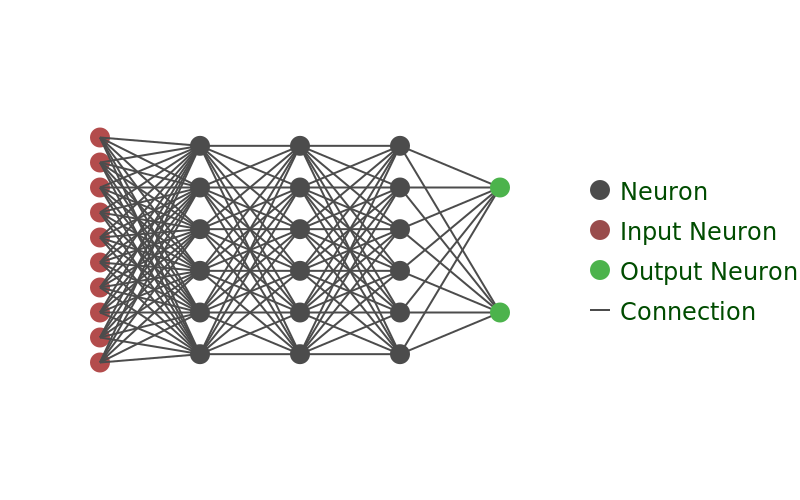

In [36]:
w, h = 800, 500
surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
ctx = cairo.Context (surface)
ctx.set_source_rgb(1, 1, 1)
ctx.rectangle(0,0,w,h)
ctx.fill()
    

layers = [10, 6, 6, 6, 2]

r = 10

i = 0

prev = []
for l in layers:
    i += 100
    x = i
    c = (0.3, 0.3, 0.3)
    if l == 2:
        c = (0.3, 0.7, 0.3)
        
    if l == 10:
        c = (0.7, 0.3, 0.3)
        
    for n in range(l):
        y = 250 * (n+0.5-l/2)/l + 250
        
        for p in prev:
            ctx.set_source_rgb(0.3, 0.3, 0.3)
            ctx.move_to(x, y)
            ctx.line_to(*p)
            ctx.stroke()
            
        ctx.set_source_rgb(*c)
        ctx.arc(x, y, r, 0, 2 * math.pi)
        ctx.fill()
        ctx.stroke()
    prev = []
    for n in range(l):
        y = 250 * (n+0.5-l/2)/l + 250
        prev.append((x, y))

# Key
ctx.set_source_rgb(0.3, 0.3, 0.3)
ctx.arc(600, 190, r, 0, 2 * math.pi)
ctx.fill()
ctx.stroke() 

ctx.set_source_rgb(0.6, 0.3, 0.3)
ctx.arc(600, 230, r, 0, 2 * math.pi)
ctx.fill()
ctx.stroke() 

ctx.set_source_rgb(0.3, 0.7, 0.3)
ctx.arc(600, 270, r, 0, 2 * math.pi)
ctx.fill()
ctx.stroke() 

ctx.set_source_rgb(0.3, 0.3, 0.3)
ctx.move_to(590, 310)
ctx.line_to(610, 310)
ctx.stroke()

# Text
ctx.select_font_face('Sans')
ctx.set_font_size(24) # em-square height is 90 pixels

ctx.move_to(620, 200) # move to point (x, y) = (10, 90)
ctx.set_source_rgb(0.00, 0.3, 0.00) # yellow
ctx.show_text('Neuron')

ctx.move_to(620, 240) # move to point (x, y) = (10, 90)
ctx.set_source_rgb(0.00, 0.3, 0.00) # yellow
ctx.show_text('Input Neuron')

ctx.move_to(620, 280) # move to point (x, y) = (10, 90)
ctx.set_source_rgb(0.00, 0.3, 0.00) # yellow
ctx.show_text('Output Neuron')


ctx.move_to(620, 320) # move to point (x, y) = (10, 90)
ctx.set_source_rgb(0.00, 0.3, 0.00) # yellow
ctx.show_text('Connection')


surface.write_to_png('nn.png')
Image('nn.png')

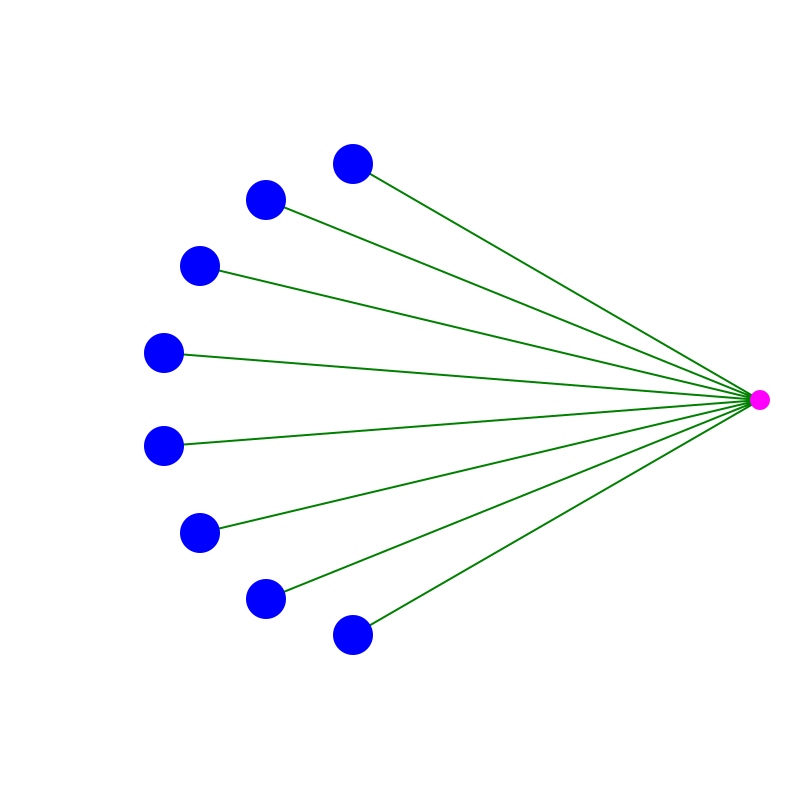

In [39]:
from image_util import *
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

%matplotlib inline

es = [{'r':0.9,'a':0}]
ds = []

for i in range(8):
    a = math.pi/2+math.pi*(i+0.5)/8
    ds.append({'r':0.6, # uniform angle
               'a':a})
    
s = draw_des(ds, es, 800, 800)
s.write_to_png('fan_curve.png')
Image('fan_curve.png')

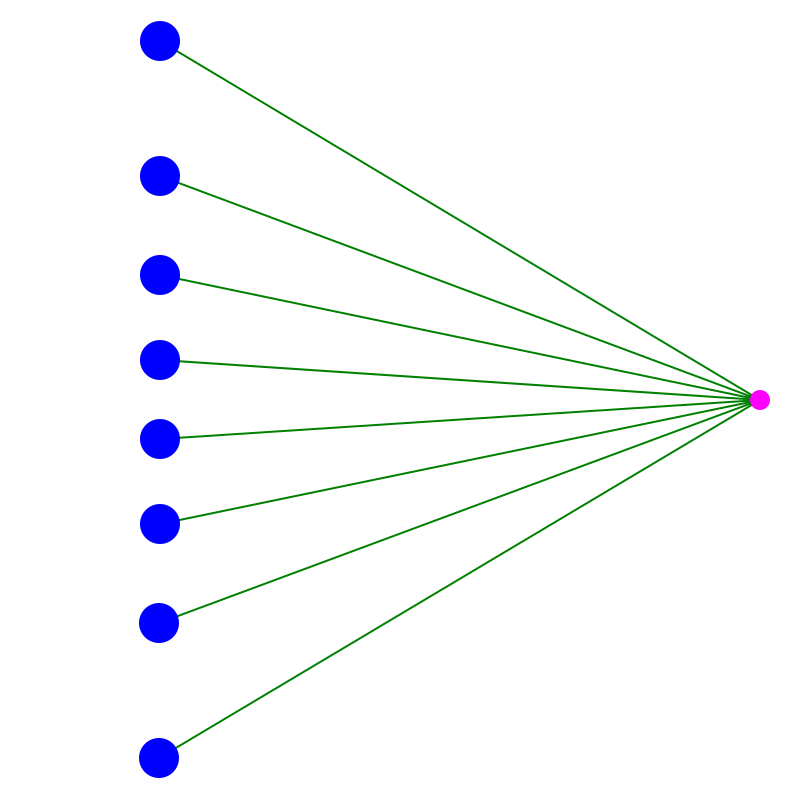

In [41]:
from image_util import *
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

%matplotlib inline

es = [{'r':0.9,'a':0}]
ds = []

for i in range(8):
    a = math.pi/2+math.pi*(i+0.5)/8
    st = 0.6*math.sin(a)/(0.9**2 + 0.6**2 - 2*(0.6)*(0.9)*math.cos(a))
    t = math.asin(st)
    y = math.tan(t)*(0.9+1)
    x = 0.6
    a = math.pi+math.atan(y/x)
    r = (y**2+0.6**2)**0.5
    
    ds.append({'r':r, # uniform angle
               'a':a})
    
s = draw_des(ds, es, 800, 800)
s.write_to_png('fan_flaten.png')
Image('fan_flaten.png')



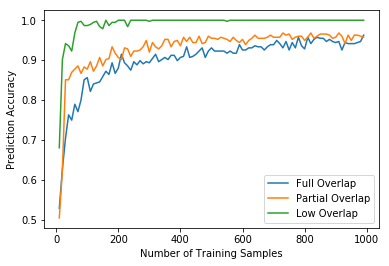

In [45]:
import pandas as pd
scores = pd.read_csv('scores_simulation_ring_of_8_overlap_varied.csv')
ax = scores.plot(x='Number of Samples')
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('Prediction Accuracy')
plt.savefig('r8ac.png')